In [1]:
import pandas as pd
import datetime
from os import listdir
import os, os.path
from os.path import isfile, join
import numpy as np
import csv
import re
import pandas as pd
import pm4py
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.log.exporter.xes import exporter as xes_exporter
from pm4py.objects.log.util import dataframe_utils
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_categorias_autores=pd.read_csv("logCT2.csv",index_col=0)
df_categorias_autores

,case:concept:name,concept:name,Specific operation,time:timestamp,Report,Question,Year,Category,Type
0,A1 P2 BPI 2020,Calculate cycle time,Calculate cycle time of the whole process for ...,2021-10-19 12:47:13.651481,A1,P2,2020,Academic,Analyze Cycle Time
1,A1 P2 BPI 2020,Compare cycle time,,2021-10-19 12:47:13.659459,A1,P2,2020,Academic,Analyze Cycle Time
2,A2 P2 BPI 2020,Calculate cycle time,Get cycle time from the previous question,2021-10-19 12:47:13.666495,A2,P2,2020,Student,Analyze Cycle Time
3,A2 P2 BPI 2020,Compare cycle time,,2021-10-19 12:47:13.666495,A2,P2,2020,Student,Analyze Cycle Time
4,A7 P2 BPI 2020,Calculate throughput,,2021-10-19 12:47:13.682150,A7,P2,2020,Academic,Analyze Cycle Time
...,...,...,...,...,...,...,...,...,...
943,A19 P1 BPI 2020,Group traces,Group traces by year,2021-10-19 12:47:20.534786,A19,P1,2020,Professional,Manipulation
944,A19 P1 BPI 2020,Group traces,Group traces by activities,2021-10-19 12:47:20.534786,A19,P1,2020,Professional,Manipulation
945,A19 P1 BPI 2020,Calculate statistics,Calculate Statistics of activities,2021-10-19 12:47:20.557196,A19,P1,2020,Professional,Calculate statistics
946,A19 P1 BPI 2020,Calculate throughput,,2021-10-19 12:47:20.567144,A19,P1,2020,Professional,Analyze Cycle Time


In [3]:
winners=['A1-2015',"A2-2015","A13-2017","A18-2017","A22-2017","A4-2019","A12-2019","A1-2020","A2-2020"]
df_categorias_autores["repYear"]=[rep+"-"+str(year) for rep,year in zip(df_categorias_autores['Report'],df_categorias_autores['Year'])]

In [4]:
df_categorias_autores[df_categorias_autores["repYear"]=="A18-2017"]

,case:concept:name,concept:name,Specific operation,time:timestamp,Report,Question,Year,Category,Type,repYear
805,A18 P1 BPI 2017,Filter events,Filter events by attributes,2021-10-19 12:47:19.653883,A18,P1,2017,Professional,Manipulation,A18-2017
806,A18 P1 BPI 2017,Calculate cycle time,Calculate cycle time for all pairs of events f...,2021-10-19 12:47:19.653883,A18,P1,2017,Professional,Analyze Cycle Time,A18-2017
807,A18 P1 BPI 2017,Identify bottlenecks,Identify activities as bottlenecks applying te...,2021-10-19 12:47:19.669529,A18,P1,2017,Professional,Analyze Cycle Time,A18-2017
808,A18 P1 BPI 2017,Filter events,Filter events by resources,2021-10-19 12:47:19.669529,A18,P1,2017,Professional,Manipulation,A18-2017
809,A18 P1 BPI 2017,Calculate cycle time,Calculate cycle time of only a subset of pairs...,2021-10-19 12:47:19.669529,A18,P1,2017,Professional,Analyze Cycle Time,A18-2017
810,A18 P1 BPI 2017,Identify bottlenecks,Identify activities as bottlenecks applying te...,2021-10-19 12:47:19.685187,A18,P1,2017,Professional,Analyze Cycle Time,A18-2017


In [5]:
def jaccardIndex(list1,list2):
    set1=set(list1)
    set2=set(list2)
    intersection = set1.intersection(set2)
    tamIntersection=len(list(intersection))
    union = set1.union(set2)
    tamUnion=len(list(union))
    similitud=float(tamIntersection)/tamUnion
    return similitud

In [6]:
def overlapIndex(list1,list2):
    set1=set(list1)
    set2=set(list2)
    intersection = set1.intersection(set2)
    len1=len(list(set1))
    len2=len(list(set2))
    overlapIndex=float(len(list(intersection)))/min([len1,len2])
    return overlapIndex

In [7]:
def comparePairsDF(df,func,qy):
    
    parAnalysis=[]
    categories=[]
    index=[]
    questionYear=[]
    
    idsAnalisis=df["repYear"].unique()
    cat1=""
    cat2=""
    print(len(idsAnalisis))
    
    for i in range(len(idsAnalisis)-1):
        #print(idsAnalisis)
        #print("----------------------")
        ident=idsAnalisis[i]
        print("i="+" "+str(i))
        operacionesIdent1=df[df["repYear"]==ident]['concept:name']
        print(ident)
        print("----------------------")
        #print("segunda lista")
        #print(idsAnalisis)
        if ident in winners:
            cat1="W"
        else:
            cat1="NW"
        j=0
        for j in range(i+1,len(idsAnalisis)):
            ident2=idsAnalisis[j]
            #print("identificador dos")
            print(ident+" "+ident2)

            operacionesIdent2=df[df["repYear"]==ident2]['concept:name']

            if ident2 in winners:
                cat2="W"
            else:
                cat2="NW"

            cats=cat1+"-"+cat2

            categories.append(cats)
            index.append(func(operacionesIdent1,operacionesIdent2))
            parAnalysis.append(ident+"-"+ident2)
            questionYear.append(qy)
            
    dict_df={"parAnalisis":parAnalysis,"Categories":categories,"Comparison index":index,"questionYear":questionYear}
    df_analisis=pd.DataFrame.from_dict(dict_df)
    #print(df_analisis)
    return df_analisis

In [8]:
agrupaciones_años_preguntas=df_categorias_autores.groupby(["Question","Year"])
dict_df_analysis={"parAnalisis":[],"Categories":[],"Comparison index":[],"questionYear":[]}
df_analisis_similarity=pd.DataFrame.from_dict(dict_df_analysis)

for name, df_group in agrupaciones_años_preguntas:
    #print(df_group)
    df_año_pregunta=comparePairsDF(df_group,overlapIndex,name)
    df_analisis_similarity=pd.concat([df_analisis_similarity,df_año_pregunta])

21
i= 0
A1-2017
----------------------
A1-2017 A2-2017
A1-2017 A5-2017
A1-2017 A6-2017
A1-2017 A7-2017
A1-2017 A8-2017
A1-2017 A9-2017
A1-2017 A10-2017
A1-2017 A11-2017
A1-2017 A13-2017
A1-2017 A14-2017
A1-2017 A15-2017
A1-2017 A16-2017
A1-2017 A17-2017
A1-2017 A21-2017
A1-2017 A22-2017
A1-2017 A23-2017
A1-2017 A12-2017
A1-2017 A19-2017
A1-2017 A3-2017
A1-2017 A18-2017
i= 1
A2-2017
----------------------
A2-2017 A5-2017
A2-2017 A6-2017
A2-2017 A7-2017
A2-2017 A8-2017
A2-2017 A9-2017
A2-2017 A10-2017
A2-2017 A11-2017
A2-2017 A13-2017
A2-2017 A14-2017
A2-2017 A15-2017
A2-2017 A16-2017
A2-2017 A17-2017
A2-2017 A21-2017
A2-2017 A22-2017
A2-2017 A23-2017
A2-2017 A12-2017
A2-2017 A19-2017
A2-2017 A3-2017
A2-2017 A18-2017
i= 2
A5-2017
----------------------
A5-2017 A6-2017
A5-2017 A7-2017
A5-2017 A8-2017
A5-2017 A9-2017
A5-2017 A10-2017
A5-2017 A11-2017
A5-2017 A13-2017
A5-2017 A14-2017
A5-2017 A15-2017
A5-2017 A16-2017
A5-2017 A17-2017
A5-2017 A21-2017
A5-2017 A22-2017
A5-2017 A23-2017
A5-20

A2-2020 A12-2020
A2-2020 A13-2020
A2-2020 A18-2020
A2-2020 A25-2020
A2-2020 A26-2020
A2-2020 A28-2020
A2-2020 A35-2020
A2-2020 A37-2020
A2-2020 A11-2020
A2-2020 A16-2020
A2-2020 A24-2020
A2-2020 A19-2020
A2-2020 A27-2020
A2-2020 A31-2020
i= 1
A7-2020
----------------------
A7-2020 A10-2020
A7-2020 A12-2020
A7-2020 A13-2020
A7-2020 A18-2020
A7-2020 A25-2020
A7-2020 A26-2020
A7-2020 A28-2020
A7-2020 A35-2020
A7-2020 A37-2020
A7-2020 A11-2020
A7-2020 A16-2020
A7-2020 A24-2020
A7-2020 A19-2020
A7-2020 A27-2020
A7-2020 A31-2020
i= 2
A10-2020
----------------------
A10-2020 A12-2020
A10-2020 A13-2020
A10-2020 A18-2020
A10-2020 A25-2020
A10-2020 A26-2020
A10-2020 A28-2020
A10-2020 A35-2020
A10-2020 A37-2020
A10-2020 A11-2020
A10-2020 A16-2020
A10-2020 A24-2020
A10-2020 A19-2020
A10-2020 A27-2020
A10-2020 A31-2020
i= 3
A12-2020
----------------------
A12-2020 A13-2020
A12-2020 A18-2020
A12-2020 A25-2020
A12-2020 A26-2020
A12-2020 A28-2020
A12-2020 A35-2020
A12-2020 A37-2020
A12-2020 A11-2020
A

In [9]:
len(df_analisis_similarity[df_analisis_similarity["Categories"]=="W-W"])

9

In [10]:
df_analisis_similarity

,parAnalisis,Categories,Comparison index,questionYear
0,A1-2017-A2-2017,NW-NW,0.000000,"(P1, 2017)"
1,A1-2017-A5-2017,NW-NW,0.400000,"(P1, 2017)"
2,A1-2017-A6-2017,NW-NW,0.833333,"(P1, 2017)"
3,A1-2017-A7-2017,NW-NW,0.500000,"(P1, 2017)"
4,A1-2017-A8-2017,NW-NW,0.250000,"(P1, 2017)"
...,...,...,...,...
73,A35-2020-A16-2020,NW-NW,0.000000,"(P6, 2020)"
74,A35-2020-A30-2020,NW-NW,0.500000,"(P6, 2020)"
75,A37-2020-A16-2020,NW-NW,0.500000,"(P6, 2020)"
76,A37-2020-A30-2020,NW-NW,0.333333,"(P6, 2020)"


In [11]:
len(df_analisis_similarity[df_analisis_similarity["questionYear"]==("P5",2015)])

36

In [12]:
len(df_analisis_similarity[df_analisis_similarity["Categories"]=="NW-NW"])

755

In [13]:
df_analisis_similarity=df_analisis_similarity.reset_index()
df_analisis_similarity['Categories']=df_analisis_similarity['Categories'].replace("NW-W", "W-NW")

In [14]:
df_analisis_similarity[(df_analisis_similarity["Categories"]=="W-W")]

,index,parAnalisis,Categories,Comparison index,questionYear
149,149,A13-2017-A22-2017,W-W,0.500000,"(P1, 2017)"
154,154,A13-2017-A18-2017,W-W,0.333333,"(P1, 2017)"
199,199,A22-2017-A18-2017,W-W,0.333333,"(P1, 2017)"
210,0,A1-2020-A2-2020,W-W,1.000000,"(P1, 2020)"
410,29,A4-2019-A12-2019,W-W,0.800000,"(P2, 2019)"
447,0,A1-2020-A2-2020,W-W,1.000000,"(P2, 2020)"
742,6,A2-2015-A1-2015,W-W,0.250000,"(P5, 2015)"
772,0,A1-2020-A2-2020,W-W,1.000000,"(P5, 2020)"
908,0,A1-2020-A2-2020,W-W,0.500000,"(P6, 2020)"


In [15]:
questionYearCategories=df_analisis_similarity.groupby("Categories").apply(lambda x: np.mean(x["Comparison index"]))
questionYearCategories
#for key, item in questionYearCategories:
    #print(questionYearCategories.get_group(key),"\n\n")

Categories
NW-NW    0.480633
W-NW     0.591833
W-W      0.635185
dtype: float64

In [16]:
questionYearCategoriesStd=df_analisis_similarity.groupby("Categories").apply(lambda x: x["Comparison index"].std(ddof=0))
questionYearCategoriesStd

Categories
NW-NW    0.334181
W-NW     0.323630
W-W      0.296944
dtype: float64

In [17]:
questionYearCategoriesVar=df_analisis_similarity.groupby("Categories").apply(lambda x: x["Comparison index"].var(ddof=0))
questionYearCategoriesVar

Categories
NW-NW    0.111677
W-NW     0.104736
W-W      0.088176
dtype: float64

In [18]:
#0->NW-NW, 1->W-NW, 2->W-W
from scipy import stats
agrupado_categorias=df_analisis_similarity.groupby("Categories")
agrupado_categorias.groups.keys()

dict_keys(['NW-NW', 'W-NW', 'W-W'])

In [19]:
#NW-NW y W-NW
stats.kruskal(agrupado_categorias.get_group("NW-NW")["Comparison index"],agrupado_categorias.get_group("W-NW")["Comparison index"])

KruskalResult(statistic=18.604148314642387, pvalue=1.608701110203457e-05)

In [20]:
stats.kruskal(agrupado_categorias.get_group("W-W")["Comparison index"],agrupado_categorias.get_group("W-NW")["Comparison index"])

KruskalResult(statistic=0.027399695300398288, pvalue=0.8685279933534252)

In [21]:
stats.kruskal(agrupado_categorias.get_group("W-W")["Comparison index"],agrupado_categorias.get_group("NW-NW")["Comparison index"])

KruskalResult(statistic=1.3137959529654146, pvalue=0.2517085258323675)

In [22]:
stats.kruskal(agrupado_categorias.get_group("W-W")["Comparison index"],agrupado_categorias.get_group("W-NW")["Comparison index"],agrupado_categorias.get_group("NW-NW")["Comparison index"])

KruskalResult(statistic=19.458835235246813, pvalue=5.950693975813881e-05)

(array([162.,   5.,  36.,  92.,  29., 168.,  85.,  29.,  22., 127.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

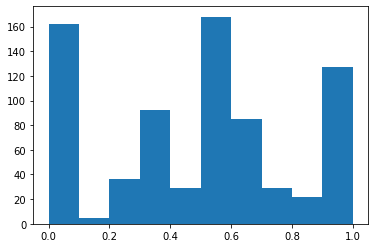

In [23]:
plt.hist(agrupado_categorias.get_group("NW-NW")["Comparison index"])

(array([1., 2., 0., 2., 0., 0., 0., 1., 0., 3.]),
 array([0.25 , 0.325, 0.4  , 0.475, 0.55 , 0.625, 0.7  , 0.775, 0.85 ,
        0.925, 1.   ]),
 <BarContainer object of 10 artists>)

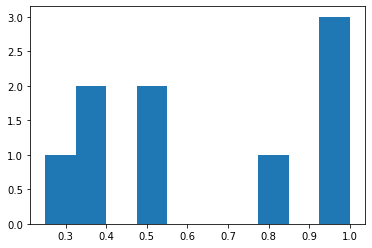

In [24]:
plt.hist(agrupado_categorias.get_group("W-W")["Comparison index"])

(array([26.,  1., 10., 24.,  6., 44., 40.,  6.,  4., 61.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

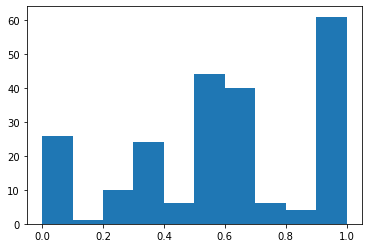

In [26]:
plt.hist(agrupado_categorias.get_group("W-NW")["Comparison index"])

In [30]:
from scipy.stats import shapiro
stat,p=shapiro(agrupado_categorias.get_group("W-NW")["Comparison index"])
print("Pvalue normality W-NW: "+str(p))

Pvalue normality W-NW: 6.766027321747359e-11


In [31]:
stat,p=shapiro(agrupado_categorias.get_group("NW-NW")["Comparison index"])
print("Pvalue normality NW-NW: "+str(p))

Pvalue normality NW-NW: 1.690158920142708e-20


In [32]:
stat,p=shapiro(agrupado_categorias.get_group("NW-NW")["Comparison index"])
print("Pvalue normality W-W: "+str(p))

Pvalue normality W-W: 1.690158920142708e-20
